# Lab 6 - Eliot Harrell - Analyze New Hampshire Census Data With AI

## Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

Collect NH (fips = 33) Data in SQL and Add to Dataframe

In [3]:
sql = """
     select * from name_income
     where fips = '33'
     """

In [4]:
import pandas as pd

nh_df = pd.read_sql(sql, con=conn)
nh_df.head() #show the top 5 rows

/tmp/ipykernel_15815/1349906867.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nh_df = pd.read_sql(sql, con=conn)


,fips,name,income,year
0,33,New Hampshire,56768,2005
1,33,New Hampshire,59683,2006
2,33,New Hampshire,62369,2007
3,33,New Hampshire,63731,2008
4,33,New Hampshire,60567,2009


Install AI Assistants

In [5]:
! pip install jupyter-ai-magics[all] -q

In [6]:
import warnings
warnings.simplefilter('ignore')

In [7]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [8]:
%load_ext jupyter_ai_magics

In [9]:
%%ai gpt4
What is included in the {nh_df}

The data included shows the income trends in New Hampshire from year 2005 to 2019. Each row of the dataset contains the following information:

- `fips`: A numerical code associated with New Hampshire, which appears to be '33' in all entries.
- `name`: The name of the state, in this case, New Hampshire.
- `income`: The annual income recorded in the state for the corresponding year.
- `year`: The specific year in which the income was recorded. It ranges from 2005 to 2019 in this data.

In [10]:
import pandas as pd

# Execute the SQL command using cursor `cur`
cur.execute("SELECT * FROM name_income")

# Fetch all rows from the last executed statement using `fetchall()` method
data = cur.fetchall()

# Get the column names for the data
column_names = [desc[0] for desc in cur.description]

# Convert the data into DataFrame
df = pd.DataFrame(data, columns = column_names)


SQL query to get population data per year in NH:

In [11]:
query = f"""
SELECT 
    p.year,
    p.pop AS population,
    ROUND(
        100.0 * (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) / LAG(p.pop) OVER (ORDER BY p.year),
        2
    ) AS growth_rate_percent
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'New Hampshire'
ORDER BY p.year;
"""

In [12]:
%%ai gpt4 -f code
using the query from {In[11]} and the previous information, make a line graph that displays the population growth rate per year in new hampshire
include the state name in the title

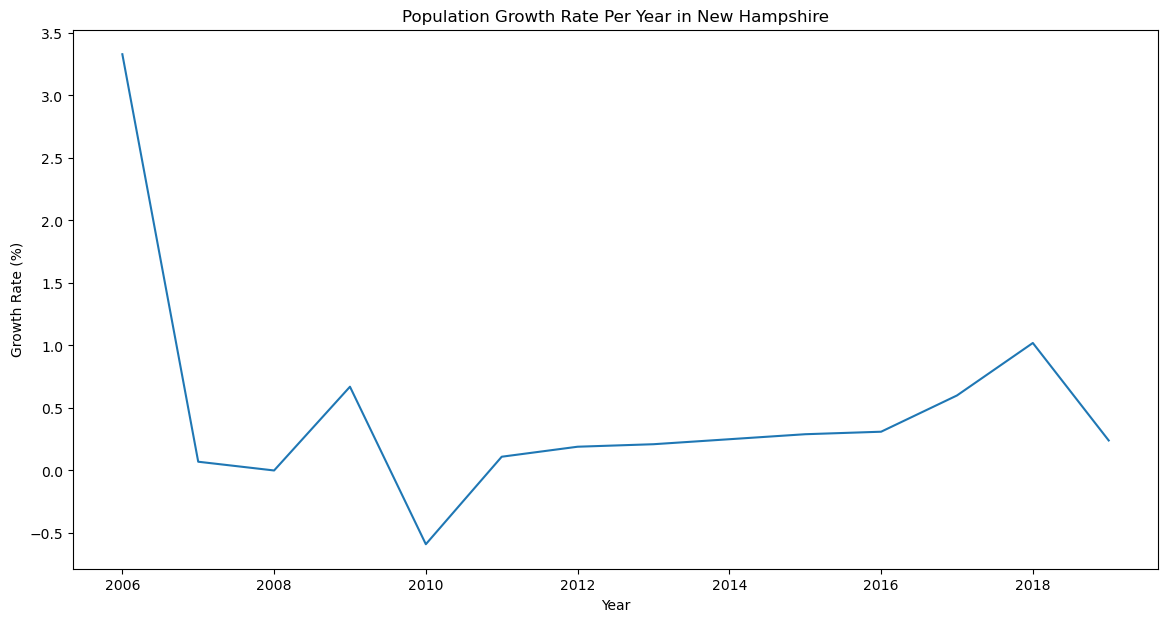

In [13]:
import matplotlib.pyplot as plt

# Define the SQL command
query = """
SELECT 
    p.year,
    p.pop AS population,
    ROUND(
        100.0 * (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) / LAG(p.pop) OVER (ORDER BY p.year),
        2
    ) AS growth_rate_percent
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'New Hampshire'
ORDER BY p.year;
"""

# Use pandas to directly turn SQL query into dataframe
df = pd.read_sql(query, conn)

# Plotting the data
plt.figure(figsize=(14,7))
plt.plot(df['year'], df['growth_rate_percent'])
plt.title("Population Growth Rate Per Year in New Hampshire")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.show()

The above graph shows the rate of population growth (and decline) between 2005 and 2019. We can see an initial decline, an anomalous spike and dip, and then a steady rise followed by a dropoff in 2019.